In [1]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from PIL import Image

def parse_inkml(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        traces = {}
        for trace in root.findall('{http://www.w3.org/2003/InkML}trace'):
            trace_id = str(trace.attrib['id'])
            coords = []
            for point in trace.text.strip().split(','):
                if point.strip() == '':
                    continue
                parts = point.strip().split()
                if len(parts) >= 2:
                    x = float(parts[0])
                    y = float(parts[1])
                    coords.append((x, y))
            traces[trace_id] = coords

        trace_groups = []
        for traceView in root.findall('.//{http://www.w3.org/2003/InkML}traceView'):
            trace_groups.append(traceView.attrib['traceDataRef'])

        return traces, trace_groups
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None, None

def normalize_and_render(traces, trace_groups=None, img_size=256, padding=10):
    all_points = []
    keys = trace_groups if trace_groups else traces.keys()

    for t_id in keys:
        if t_id in traces:
            all_points.extend(traces[t_id])
    
    if not all_points:
        raise ValueError("No valid stroke points found.")

    all_points = np.array(all_points)
    min_x, min_y = np.min(all_points, axis=0)
    max_x, max_y = np.max(all_points, axis=0)

    scale = (img_size - 2 * padding) / max(max_x - min_x, max_y - min_y + 1e-6)
    canvas = np.ones((img_size, img_size), dtype=np.uint8) * 255

    for t_id in keys:
        if t_id in traces:
            trace = np.array(traces[t_id])
            trace -= [min_x, min_y]
            trace *= scale
            trace += padding
            trace = trace.astype(np.int32)

            for i in range(1, len(trace)):
                pt1 = tuple(trace[i - 1])
                pt2 = tuple(trace[i])
                cv2.line(canvas, pt1, pt2, color=0, thickness=2)

    return canvas

def process_inkml_folder(inkml_root_dir, user_output_dir):
    output_img_dir = os.path.join(user_output_dir, "processed_images")

    # Recreate the output directory
    if os.path.exists(user_output_dir):
        shutil.rmtree(user_output_dir)
    os.makedirs(output_img_dir, exist_ok=True)

    for root, _, files in os.walk(inkml_root_dir):
        for file in files:
            if file.endswith('.inkml'):
                file_path = os.path.join(root, file)
                traces, trace_groups = parse_inkml(file_path)
                if traces:
                    img = normalize_and_render(traces, trace_groups)
                    base_name = os.path.splitext(file)[0]
                    img_path = os.path.join(output_img_dir, f"{base_name}.png")
                    Image.fromarray(img).save(img_path)
                    print(f"Processed: {file}")

# # Run the conversion
# inkml_dir = '/kaggle/input/crohme2019/crohme2019/crohme2019/train'
# user_output_dir = 'results_train'
# process_inkml_folder(inkml_dir, user_output_dir)

# print(f"\n✅ Done! Processed images saved in: {user_output_dir}/processed_images")


In [2]:
splits = {
    'train': 'kaggle/input/crohme2019/crohme2019/crohme2019/train',
    'valid': 'kaggle/input/crohme2019/crohme2019/crohme2019/valid',
    'test' : 'kaggle/input/crohme2019/crohme2019/crohme2019/test',
}

for split, inkml_dir in splits.items():
    out_dir = f'results_{split}'
    img_dir = os.path.join(out_dir, 'processed_images')

    # Only run conversion if the processed_images folder is missing or empty
    if not os.path.isdir(img_dir) or not os.listdir(img_dir):
        print(f"🚀 Processing {split} split...")
        process_inkml_folder(inkml_dir, out_dir)
        print(f"✅ {split.capitalize()} images saved to: {img_dir}\n")
    else:
        print(f"✅ {split.capitalize()} images already exist at: {img_dir}\n")

✅ Train images already exist at: results_train/processed_images

✅ Valid images already exist at: results_valid/processed_images

✅ Test images already exist at: results_test/processed_images



In [3]:
splits = {
    'train': 'kaggle/input/crohme2019/crohme2019_train.txt',
    'valid': 'kaggle/input/crohme2019/crohme2019_valid.txt',
    'test':  'kaggle/input/crohme2019/crohme2019_test.txt',
}

exclude_rels = ['Above','Below','Inside','NoRel','Right','Sub','Sup']

for split, filepath in splits.items():
    vocab = set()
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            # parts[1] is the token sequence
            tokens = parts[1].split()
            vocab.update(tokens)

    # remove the relation symbols, but add them at the end
    syms = sorted(v for v in vocab if v not in exclude_rels)
    syms += exclude_rels

    outname = f'{split}_vocab.txt'
    with open(outname, 'w', encoding='utf-8') as out:
        for sym in syms:
            out.write(sym + '\n')

    print(f'✅ Wrote {len(syms)} symbols to {outname}')



✅ Wrote 108 symbols to train_vocab.txt
✅ Wrote 108 symbols to valid_vocab.txt
✅ Wrote 108 symbols to test_vocab.txt


In [31]:
# Custom dataset
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

class Vocab(object):
    def __init__(self, vocab_file):
        self.word2index = {}
        self.index2word = {}
        with open(vocab_file, 'r') as f:
            for i, line in enumerate(f):
                word = line.strip()
                self.word2index[word] = i
                self.index2word[i] = word
        self.word2index['<blank>'] = len(self.word2index)
        self.index2word[self.word2index['<blank>']] = '<blank>'

# Custom Dataset Class

class CROHMEDataset(Dataset):
    def __init__(self, img_dir, label_file, vocab, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.vocab = vocab
        self.samples = []

        with open(label_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 2:
                    print(f"⚠️ Skipping malformed line: {line.strip()}")
                    # Attempt to delete corresponding image if found
                    if parts and parts[0].endswith('.png'):
                        image_path = os.path.join(self.img_dir, parts[0])
                        if os.path.exists(image_path):
                            os.remove(image_path)
                            print(f"🗑️ Deleted image: {image_path}")
                    continue

                img_name, label = parts
                self.samples.append((img_name, label))
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, label = self.samples[idx]
        img_name = os.path.basename(img_name)
        img_name = os.path.splitext(img_name)[0] + '.png'
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            label_indices = [self.vocab.word2index[word] for word in label.split()]
            return image, torch.tensor(label_indices, dtype=torch.long)

        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")
            return None
    
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None, None
    images, labels = zip(*batch)
    image_tensors = torch.stack(images)
    label_lengths = [len(label) for label in labels]
    padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)
    return image_tensors, padded_labels, label_lengths



In [32]:
# Testing
vocab = Vocab('train_vocab.txt')
input = '- Right \\sqrt Inside 2'.split()
output = [vocab.word2index[word] for word in input]
output # Should be [4, 105, 66, 103, 9]


[4, 105, 66, 103, 9]

In [49]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F

# Image transform
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomRotation(degrees=2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load vocab files
train_vocab = Vocab('train_vocab.txt')
test_vocab = Vocab('test_vocab.txt')
valid_vocab  = Vocab('valid_vocab.txt')

# Dataset paths
train_img_dir = 'results_train/processed_images'
valid_img_dir = 'results_valid/processed_images'
test_img_dir  = 'results_test/processed_images'

train_labels = 'kaggle/input/crohme2019/crohme2019_train.txt'
valid_labels = 'kaggle/input/crohme2019/crohme2019_valid.txt'
test_labels  = 'kaggle/input/crohme2019/crohme2019_test.txt'

# Datasets
train_set = CROHMEDataset(train_img_dir, train_labels, train_vocab, transform)
valid_set = CROHMEDataset(valid_img_dir, valid_labels, valid_vocab, transform)
test_set  = CROHMEDataset(test_img_dir, test_labels, test_vocab, transform)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Set vocab for training loop
vocab = train_vocab

⚠️ Skipping malformed line: crohme2019/test/UN19_1001_em_0.inkml


In [7]:
pngs = os.listdir('results_train/processed_images')
print(f"PNG count: {len(pngs)}")
with open('kaggle/input/crohme2019/crohme2019_train.txt') as f:
    print(f"Label lines: {len(f.readlines())}")

PNG count: 8900
Label lines: 8900


In [29]:
len(valid_loader)

31

In [50]:
#sanity check

# pick whichever split you want to check
img_dir   = 'results_train/processed_images'      
label_file= 'kaggle/input/crohme2019/crohme2019_train.txt'      
vocab     = 'valid_train.txt'        # your Vocab instance

# 1) build the dataset
ds = CROHMEDataset(img_dir, label_file, train_vocab, transform=None)

# 2) list all png files in the folder
png_files = set(f for f in os.listdir(img_dir) if f.lower().endswith('.png'))

# 3) list all png names that the dataset actually expects
expected = set()
for img_name, _ in ds.samples:
    base = os.path.basename(img_name)
    png = os.path.splitext(base)[0] + '.png'
    expected.add(png)

# 4) find any on‐disk files that never got referenced
extra_on_disk = png_files - expected
# 5) find any expected files that are missing from disk
missing_on_disk = expected - png_files

print(f"Dataset length:            {len(ds)} samples")
print(f"PNG files in directory:    {len(png_files)} files")
print(f"Unreferenced PNGs (on-disk but not in labels): {len(extra_on_disk)}")
print(f"Missing PNGs  (in labels but not on-disk):     {len(missing_on_disk)}")

if extra_on_disk:
    print("Some files are never loaded by your dataset:")
    for fn in list(extra_on_disk)[:10]:
        print("  ", fn)
if missing_on_disk:
    print("Some labels point to missing files:")
    for fn in list(missing_on_disk)[:10]:
        print("  ", fn)


Dataset length:            8900 samples
PNG files in directory:    8900 files
Unreferenced PNGs (on-disk but not in labels): 0
Missing PNGs  (in labels but not on-disk):     0


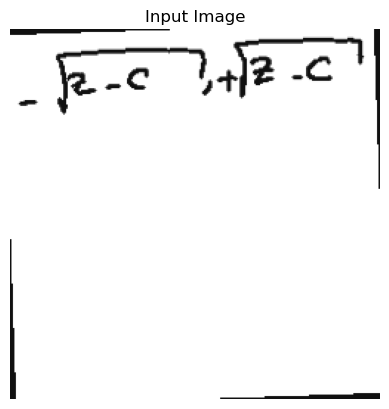

Label Tokens: ['-', 'Right', '\\sqrt', 'Inside', 'z', 'Right', '-', 'Right', 'c', 'NoRel', 'COMMA', 'Right', '+', 'Right', '\\sqrt', 'Inside', 'z', 'Right', '-', 'Right', 'c']
Decoded Label: - Right \sqrt Inside z Right - Right c NoRel COMMA Right + Right \sqrt Inside z Right - Right c


In [51]:
import matplotlib.pyplot as plt

# Pick a sample index (e.g., 0)
sample_idx = 5

# Get image tensor and label indices from the dataset
image_tensor, label_tensor = valid_set[sample_idx]  # or train_set, test_set

# Show the image (need to undo normalization)
image_np = image_tensor.numpy().transpose(1, 2, 0)  # Convert to HWC
image_np = image_np * 0.5 + 0.5  # Undo normalization to [0,1] range

plt.imshow(image_np)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Convert label tensor to text using vocab
label_tokens = [valid_vocab.index2word[idx.item()] for idx in label_tensor]
label_text = " ".join(label_tokens)

print("Label Tokens:", label_tokens)
print("Decoded Label:", label_text)

cnn.0.weight                              requires_grad=False
cnn.1.weight                              requires_grad=False
cnn.1.bias                                requires_grad=False
cnn.4.0.conv1.weight                      requires_grad=False
cnn.4.0.bn1.weight                        requires_grad=False
cnn.4.0.bn1.bias                          requires_grad=False
cnn.4.0.conv2.weight                      requires_grad=False
cnn.4.0.bn2.weight                        requires_grad=False
cnn.4.0.bn2.bias                          requires_grad=False
cnn.4.1.conv1.weight                      requires_grad=False
cnn.4.1.bn1.weight                        requires_grad=False
cnn.4.1.bn1.bias                          requires_grad=False
cnn.4.1.conv2.weight                      requires_grad=False
cnn.4.1.bn2.weight                        requires_grad=False
cnn.4.1.bn2.bias                          requires_grad=False
cnn.5.0.conv1.weight                      requires_grad=True
cnn.5.0.b

Learning Rate: 0.000013

 Epoch 11/30 completed in 99.60s — Train Loss: 1.0943, Val Loss: 1.1267, Train WER: 0.2019, Val WER: 0.2167
💾 Best model saved.
Epoch 11/30, Train Loss: 1.0943, Val Loss: 1.1267, Train WER: 0.2019, Val WER: 0.2167


Learning Rate: 0.000013

 Epoch 12/30 completed in 108.02s — Train Loss: 1.0925, Val Loss: 1.1206, Train WER: 0.2073, Val WER: 0.2172
💾 Best model saved.
Epoch 12/30, Train Loss: 1.0925, Val Loss: 1.1206, Train WER: 0.2073, Val WER: 0.2172


Learning Rate: 0.000013

 Epoch 13/30 completed in 128.09s — Train Loss: 1.0793, Val Loss: 1.1168, Train WER: 0.1921, Val WER: 0.2173
💾 Best model saved.
Epoch 13/30, Train Loss: 1.0793, Val Loss: 1.1168, Train WER: 0.1921, Val WER: 0.2173


Learning Rate: 0.000013

 Epoch 14/30 completed in 126.82s — Train Loss: 1.0815, Val Loss: 1.1087, Train WER: 0.2017, Val WER: 0.2171
💾 Best model saved.
Epoch 14/30, Train Loss: 1.0815, Val Loss: 1.1087, Train WER: 0.2017, Val WER: 0.2171


Learning Rate: 0.000013

 Epoch 15/30 completed in 133.13s — Train Loss: 1.0729, Val Loss: 1.1006, Train WER: 0.2059, Val WER: 0.2174
💾 Best model saved.
Epoch 15/30, Train Loss: 1.0729, Val Loss: 1.1006, Train WER: 0.2059, Val WER: 0.2174


Learning Rate: 0.000013

 Epoch 16/30 completed in 136.05s — Train Loss: 1.0683, Val Loss: 1.1017, Train WER: 0.2102, Val WER: 0.2176
Epoch 16/30, Train Loss: 1.0683, Val Loss: 1.1017, Train WER: 0.2102, Val WER: 0.2176


Learning Rate: 0.000013

 Epoch 17/30 completed in 155.05s — Train Loss: 1.0639, Val Loss: 1.0886, Train WER: 0.2022, Val WER: 0.2179
💾 Best model saved.
Epoch 17/30, Train Loss: 1.0639, Val Loss: 1.0886, Train WER: 0.2022, Val WER: 0.2179


Learning Rate: 0.000013

 Epoch 18/30 completed in 164.72s — Train Loss: 1.0559, Val Loss: 1.0898, Train WER: 0.2065, Val WER: 0.2180
Epoch 18/30, Train Loss: 1.0559, Val Loss: 1.0898, Train WER: 0.2065, Val WER: 0.2180


Learning Rate: 0.000013

 Epoch 19/30 completed in 151.16s — Train Loss: 1.0455, Val Loss: 1.0735, Train WER: 0.2050, Val WER: 0.2184
💾 Best model saved.
Epoch 19/30, Train Loss: 1.0455, Val Loss: 1.0735, Train WER: 0.2050, Val WER: 0.2184


Learning Rate: 0.000013

 Epoch 20/30 completed in 144.23s — Train Loss: 1.0470, Val Loss: 1.0717, Train WER: 0.2054, Val WER: 0.2189
💾 Best model saved.
Epoch 20/30, Train Loss: 1.0470, Val Loss: 1.0717, Train WER: 0.2054, Val WER: 0.2189


Learning Rate: 0.000013

 Epoch 21/30 completed in 134.52s — Train Loss: 1.0377, Val Loss: 1.0597, Train WER: 0.2076, Val WER: 0.2183
💾 Best model saved.
Epoch 21/30, Train Loss: 1.0377, Val Loss: 1.0597, Train WER: 0.2076, Val WER: 0.2183


Learning Rate: 0.000013

 Epoch 22/30 completed in 149.27s — Train Loss: 1.0266, Val Loss: 1.0492, Train WER: 0.2042, Val WER: 0.2179
💾 Best model saved.
Epoch 22/30, Train Loss: 1.0266, Val Loss: 1.0492, Train WER: 0.2042, Val WER: 0.2179


Learning Rate: 0.000013

 Epoch 23/30 completed in 142.31s — Train Loss: 1.0096, Val Loss: 1.0437, Train WER: 0.2130, Val WER: 0.2183
💾 Best model saved.
Epoch 23/30, Train Loss: 1.0096, Val Loss: 1.0437, Train WER: 0.2130, Val WER: 0.2183


Learning Rate: 0.000013

 Epoch 24/30 completed in 151.11s — Train Loss: 1.0032, Val Loss: 1.0386, Train WER: 0.2179, Val WER: 0.2181
💾 Best model saved.
Epoch 24/30, Train Loss: 1.0032, Val Loss: 1.0386, Train WER: 0.2179, Val WER: 0.2181


Learning Rate: 0.000013

 Epoch 25/30 completed in 150.10s — Train Loss: 0.9881, Val Loss: 1.0281, Train WER: 0.2063, Val WER: 0.2172
💾 Best model saved.
Epoch 25/30, Train Loss: 0.9881, Val Loss: 1.0281, Train WER: 0.2063, Val WER: 0.2172


Learning Rate: 0.000013

 Epoch 26/30 completed in 171.91s — Train Loss: 0.9848, Val Loss: 1.0176, Train WER: 0.2066, Val WER: 0.2170
💾 Best model saved.
Epoch 26/30, Train Loss: 0.9848, Val Loss: 1.0176, Train WER: 0.2066, Val WER: 0.2170


Learning Rate: 0.000013

 Epoch 27/30 completed in 152.22s — Train Loss: 0.9704, Val Loss: 1.0169, Train WER: 0.2086, Val WER: 0.2168
💾 Best model saved.
Epoch 27/30, Train Loss: 0.9704, Val Loss: 1.0169, Train WER: 0.2086, Val WER: 0.2168


Learning Rate: 0.000013

 Epoch 28/30 completed in 147.86s — Train Loss: 0.9504, Val Loss: 1.0025, Train WER: 0.2152, Val WER: 0.2168
💾 Best model saved.
Epoch 28/30, Train Loss: 0.9504, Val Loss: 1.0025, Train WER: 0.2152, Val WER: 0.2168


Learning Rate: 0.000013

 Epoch 29/30 completed in 153.83s — Train Loss: 0.9454, Val Loss: 0.9925, Train WER: 0.2054, Val WER: 0.2160
💾 Best model saved.
Epoch 29/30, Train Loss: 0.9454, Val Loss: 0.9925, Train WER: 0.2054, Val WER: 0.2160


Learning Rate: 0.000013

 Epoch 30/30 completed in 154.30s — Train Loss: 0.9288, Val Loss: 0.9819, Train WER: 0.1998, Val WER: 0.2166
💾 Best model saved.
Epoch 30/30, Train Loss: 0.9288, Val Loss: 0.9819, Train WER: 0.1998, Val WER: 0.2166


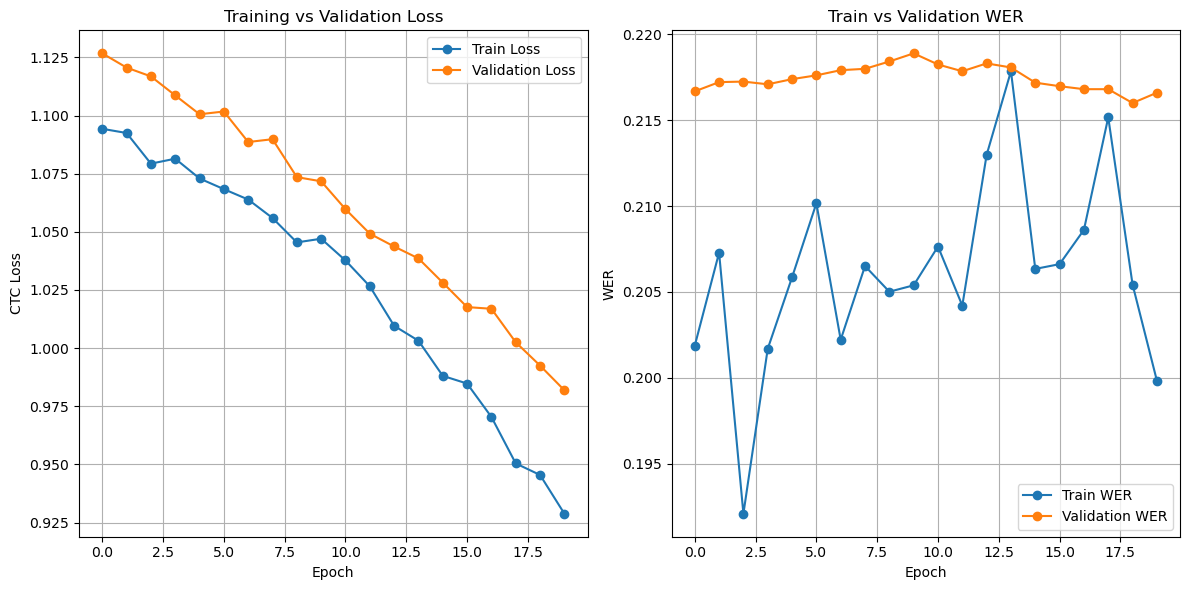

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from time import time
from tqdm import tqdm


# Function to compute Levenshtein Distance (used for WER and CER)
def levenshtein_distance(a, b):
    m = len(a) + 1
    n = len(b) + 1
    dp = np.zeros((m, n))
    
    for i in range(m):
        dp[i][0] = i
    for j in range(n):
        dp[0][j] = j
    
    for i in range(1, m):
        for j in range(1, n):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    
    return dp[m - 1][n - 1]


# Function to calculate Word Error Rate (WER)
def compute_wer(predictions, labels):
    total_words = sum(len(label.split()) for label in labels)
    errors = 0
    for pred, label in zip(predictions, labels):
        errors += levenshtein_distance(pred.split(), label.split())  # Calculate WER at word level
    return errors / total_words if total_words > 0 else 0


# Function to calculate Character Error Rate (CER)
def compute_cer(predictions, labels):
    total_chars = sum(len(label) for label in labels)
    errors = 0
    for pred, label in zip(predictions, labels):
        errors += levenshtein_distance(list(pred), list(label))  # Calculate CER at character level
    return errors / total_chars if total_chars > 0 else 0


# Model Definition (CRNN class)
class CRNN(nn.Module):
    def __init__(self, num_classes, img_size=(3,100,100)):
        super(CRNN, self).__init__()
        resnet = models.resnet18(pretrained=False)
        state_dict = torch.load("kaggle/input/pretrained-resnet18/pytorch/default/1/resnet18-f37072fd.pth")
        resnet.load_state_dict(state_dict)

        # Freeze first few layers to avoid overfitting
        for param in list(resnet.children())[:5]:
            for p in param.parameters():
                p.requires_grad = False

        # Extract CNN layers up to layer3
        self.cnn = nn.Sequential(
            *list(resnet.children())[:-3],                # Keep until layer3
            nn.BatchNorm2d(256),                          # Add BatchNorm after last conv layer
            nn.Dropout2d(p=0.3)                           # Dropout after batchnorm
        )

        # Infer feature‐map size
        with torch.no_grad():
            dummy = torch.zeros(1, *img_size)
            feat = self.cnn(dummy)          # (1, C, H, W)
            _, C, H, W = feat.shape
            
        # Bidirectional LSTM with dropout
        self.rnn = nn.LSTM(
            input_size=C*H,
            hidden_size=256,
            num_layers=2,
            dropout=0.5,              # Dropout between LSTM layers
            bidirectional=True,
            batch_first=True
        )

        self.dropout_fc = nn.Dropout(p=0.3)              # Dropout before final classification
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        
        # x = self.cnn(x)  # (B, 256, H, W)
        # x = nn.functional.adaptive_avg_pool2d(x, (1, x.size(3)))  # (B, 256, 1, W)
        # x = x.squeeze(2)  # (B, 256, W)
        # x = x.permute(0, 2, 1)  # (B, W, 256)

        #CRNN Paper Implementation
        
        x = self.cnn(x)  # (B, C, H, W)
        # Permute to (B, W, C, H) so each column becomes a sequence frame
        x = x.permute(0, 3, 1, 2)  # (B, W, C, H)
        # Flatten height and channel into a single feature vector per time step
        B, W, C, H = x.size()
        x = x.reshape(B, W, C * H)  # (B, W, C*H)
        
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x


# Training Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CRNN(num_classes=len(vocab.word2index)).to(device)
criterion = nn.CTCLoss(blank=vocab.word2index['<blank>'], zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Add this:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # Minimize the validation loss
    factor=0.5,         # Reduce LR by a factor of 0.5
    patience=2,         # Wait for 2 epochs before reducing LR
    verbose=True        # Print LR updates
)

for name, param in model.named_parameters():
    print(f"{name:40s}  requires_grad={param.requires_grad}")

train_losses = []
val_losses = []
train_wer = []
val_wer = []
train_cer = []
val_cer = []

def decode(output, vocab):
    preds = output.argmax(dim=-1)  # (B, T)
    decoded = []
    for pred in preds:
        tokens = []
        prev = -1
        for p in pred:
            if p != prev and p != vocab.word2index['<blank>']:
                tokens.append(vocab.index2word[p.item()])
            prev = p
        decoded.append(" ".join(tokens))
    return decoded
    
num_epochs = 30
best_val_loss = float('inf')

resume_training = True 
checkpoint_path = 'crnn_checkpoint.pth'

start_epoch = 10
best_val_loss = float('inf')

if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('val_loss', float('inf'))  # Optional: track best loss
    print(f"Resumed training from epoch {start_epoch} (best val loss so far: {best_val_loss:.4f})")
else:
    print("Starting fresh training.")

total_epoch = 30

for epoch in range(start_epoch, total_epoch):
    start_time = time()
    model.train()
    epoch_train_loss = 0
    epoch_train_preds = []
    epoch_train_labels = []

    pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training", leave=False)
    for images, labels, label_lengths in pbar:
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = torch.tensor(label_lengths, dtype=torch.long)

        output = model(images)
        output = output.permute(1, 0, 2)
        input_lengths = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long)

        loss = criterion(output, labels, input_lengths, label_lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        pbar.set_postfix(train_loss=loss.item())

        # Decode predictions and accumulate for WER/CER calculation
        preds = decode(output, vocab)
        labels_decoded = []
        for lbl in labels:
            tokens = [vocab.index2word[l.item()] for l in lbl if l.item() != vocab.word2index['<blank>']]
            labels_decoded.append(" ".join(tokens))
        epoch_train_preds.extend(preds)
        epoch_train_labels.extend(labels_decoded)



    # Compute Train WER and CER
    train_wer.append(compute_wer(epoch_train_preds, epoch_train_labels))
    train_cer.append(compute_cer(epoch_train_preds, epoch_train_labels))

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    epoch_time = time() - start_time

    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():
        pbar_val = tqdm(valid_loader, desc=f"[Epoch {epoch+1}] Validating", leave=False)
        for images, labels, label_lengths in pbar_val:
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = torch.tensor(label_lengths, dtype=torch.long)

            output = model(images)
            output = output.permute(1, 0, 2)
            input_lengths = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long)

            val_loss = criterion(output, labels, input_lengths, label_lengths)
            epoch_val_loss += val_loss.item()

            pbar_val.set_postfix(val_loss=val_loss.item())

            # Decode predictions and accumulate for WER/CER calculation
            preds = decode(output, vocab)
            labels_decoded = []
            for lbl in labels:
                tokens = [vocab.index2word[l.item()] for l in lbl if l.item() != vocab.word2index['<blank>']]
                labels_decoded.append(" ".join(tokens))
            epoch_val_preds.extend(preds)
            epoch_val_labels.extend(labels_decoded)

    avg_val_loss = epoch_val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Compute Validation WER and CER
    val_wer.append(compute_wer(epoch_val_preds, epoch_val_labels))
    val_cer.append(compute_cer(epoch_val_preds, epoch_val_labels))

    print(f"\n Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s — "
      f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
      f"Train WER: {train_wer[-1]:.4f}, Val WER: {val_wer[-1]:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
        }, 'crnn_best_model.pth')
        print("💾 Best model saved.")

    torch.save({
    'epoch': epoch + 1,  # next epoch to resume from
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "crnn_checkpoint.pth")
        
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train WER: {train_wer[-1]:.4f}, Val WER: {val_wer[-1]:.4f}")
    
# Plotting Loss and Accuracy Metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_wer, label='Train WER', marker='o')
plt.plot(val_wer, label='Validation WER', marker='o')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.title('Train vs Validation WER')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("crnn_training_metrics.png")
plt.show()


In [36]:
valid_vocab, len(valid_loader)

(<__main__.Vocab at 0x163a7fd10>, 31)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input d


🔍 Full GT:   z Right = Right a Right + Right b Right j
🔮 Full Pred: Right Right Right Right Right
✏️  Error:    6.0

🔍 Full GT:   r Right \geq Right 1
🔮 Full Pred: Right Right
✏️  Error:    6.0

🔍 Full GT:   t Right - Right 6
🔮 Full Pred: Right NoRel Right
✏️  Error:    7.0

🔍 Full GT:   r Right ( Right x Right )
🔮 Full Pred: Right Right Right Right
✏️  Error:    8.0

🔍 Full GT:   k Right N
🔮 Full Pred: Right Right Right
✏️  Error:    10.0

🔍 Full GT:   1 Right / Right t
🔮 Full Pred: Right Right Right Right
✏️  Error:    10.0

🔍 Full GT:   1 Right 8
🔮 Full Pred: - \sqrt - - - - - -
✏️  Error:    11.0

🔍 Full GT:   F Right \neq Right H
🔮 Full Pred: Right Right Right Right
✏️  Error:    11.0

🔍 Full GT:   2 Right \div Right 3
🔮 Full Pred: Right Right Right Right
✏️  Error:    11.0

🔍 Full GT:   1 Right 2 Right \div Right 3
🔮 Full Pred: Right Right
✏️  Error:    12.0


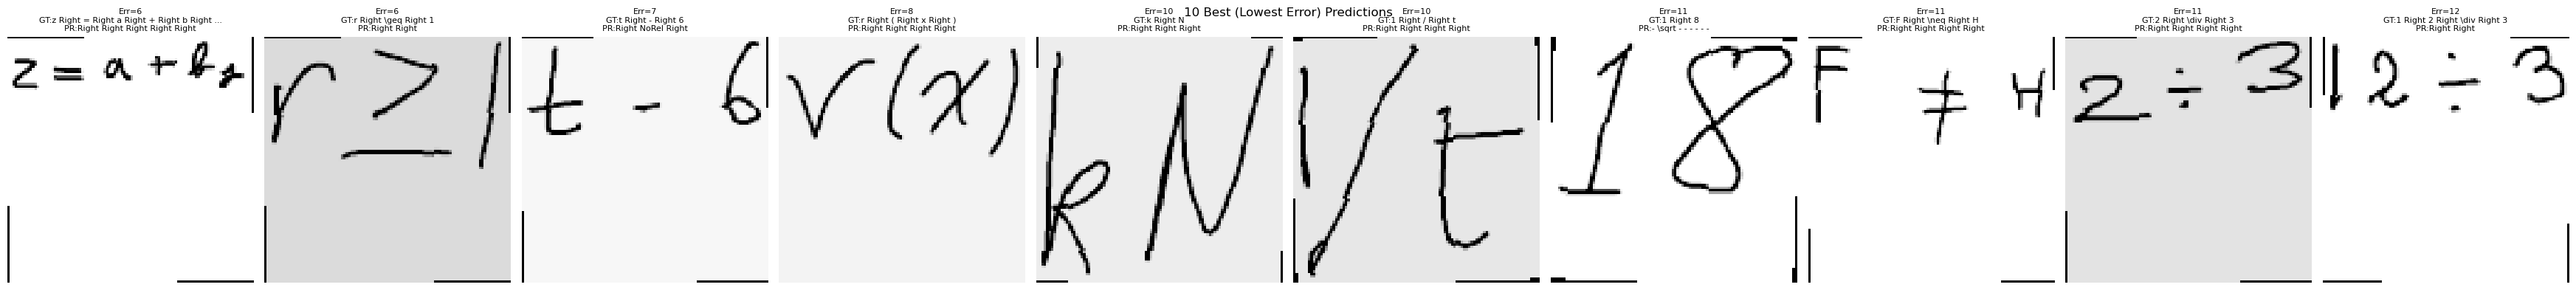

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the vali


🔍 Full GT:   \cos Right 4 Right \theta Right + Right i Right \sin Right 4 Right \theta Right = Right ( Right \cos Right \theta Right + Right i Right \sin Right \theta Right ) Sup 4
🔮 Full Pred: Right Right NoRel Right
✏️  Error:    115.0

🔍 Full GT:   [ NoRel 1 NoRel - Below 2 NoRel \sin Sup 2 NoRel ( Right 1 Right ) Right ] Right - Right [ NoRel 1 NoRel - Below 2 NoRel \sin Sup 2 NoRel ( Right 0 Right ) Right ]
🔮 Full Pred: - - - - - - - - - \sqrt -
✏️  Error:    117.0

🔍 Full GT:   \cos Right ( Right \sigma Right ) Right \gt Right 1 Right - Right 2 Right ( NoRel \sigma NoRel - Below 2 NoRel ) Sup 2 NoRel = Right 1 Right - NoRel \sigma Sup 2 NoRel - Below 2
🔮 Full Pred: - \sqrt - - - - - \sqrt
✏️  Error:    129.0

🔍 Full GT:   \sin Right ( Right 4 Right x Right ) Right = Right 4 Right \sin Right ( Right x Right ) Right \cos Sup 3 NoRel ( Right x Right ) Right - Right 4 Right \sin Sup 3 NoRel ( Right x Right ) Right \cos Right ( Right x Right )
🔮 Full Pred: Right NoRel Right NoRel Rig

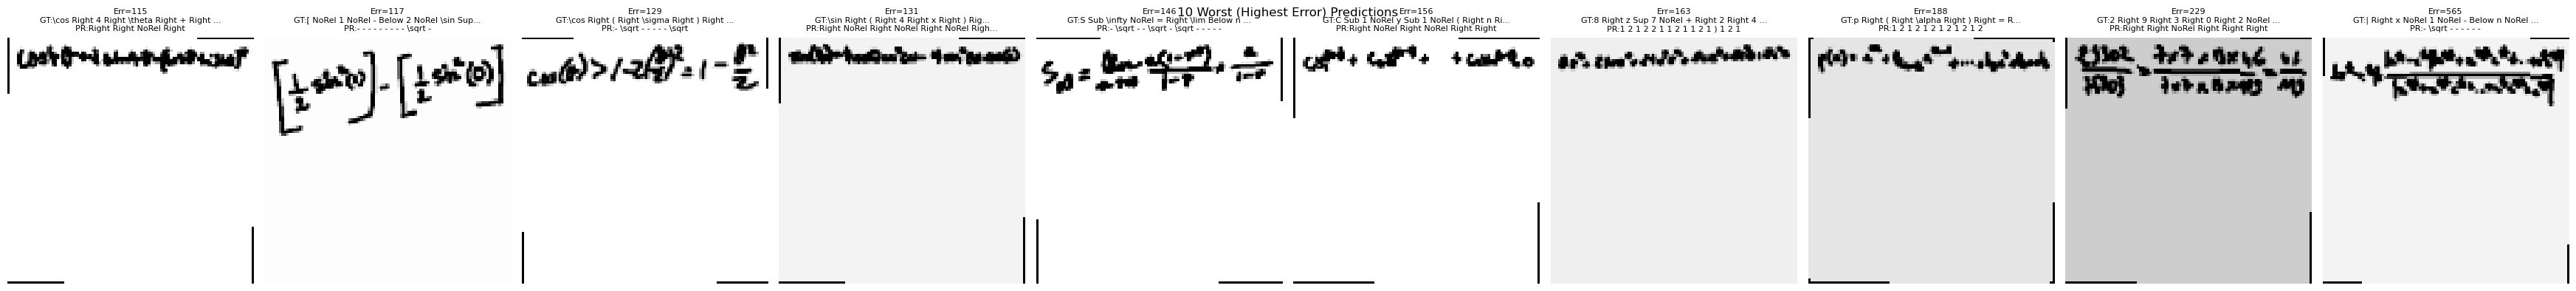

In [39]:
# Build a list of (image, true_label, pred_label, error) tuples
entries = []
model.eval()
with torch.no_grad():
    for images, labels, lengths in valid_loader:
        images = images.to(device)
        # forward pass and reshape
        output = model(images).permute(1, 0, 2)
        input_lengths = torch.full((output.size(1),), output.size(0), dtype=torch.long, device=device)
        # decode predictions
        preds = decode(output, valid_vocab)
        # collect per-sample info
        for img_tensor, pred, lbl, L in zip(images.cpu(), preds, labels, lengths):
            true_tokens = [valid_vocab.index2word[idx.item()] for idx in lbl[:L]]
            true = " ".join(true_tokens)
            error = levenshtein_distance(pred.replace(" ", ""), true.replace(" ", ""))
            entries.append((img_tensor, true, pred, error))

# sort by ascending error
entries_sorted = sorted(entries, key=lambda x: x[3])

# select top-10 best and worst
best10  = entries_sorted[:10]
worst10 = entries_sorted[-10:]

# Helper to plot a row of samples
def plot_row(samples, title, max_tokens=40):
    fig, axes = plt.subplots(1, len(samples), figsize=(3.5 * len(samples), 4))

    for ax, (img, true, pred, err) in zip(axes, samples):
        img_np = img.permute(1, 2, 0).numpy()
        cmap = 'gray' if img_np.ndim == 2 or img_np.shape[2] == 1 else None
        ax.imshow(img_np.squeeze(), cmap=cmap, vmin=0, vmax=1)
        
        # Truncate long tokens for better display
        def truncate(s, max_len=max_tokens):
            return s if len(s) <= max_len else s[:max_len] + "..."

        ax.set_title(f"Err={int(err)}\nGT:{truncate(true)}\nPR:{truncate(pred)}", fontsize=8)
        ax.axis('off')

        # Optionally: print full versions in console
        print(f"\n🔍 Full GT:   {true}")
        print(f"🔮 Full Pred: {pred}")
        print(f"✏️  Error:    {err}")

    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot best and worst
plot_row(best10, "10 Best (Lowest Error) Predictions")
plot_row(worst10, "10 Worst (Highest Error) Predictions")
